In [1]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob


import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from iminuit import Minuit


from utils import *


import seaborn as sns
from matplotlib import rcParams
from cycler import cycler


## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 20, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'brown', 'green', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [9]:
output_path = 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis256_LL0.05'
output_path_long = output_path + '_long'
save_path = 'data\\nematic_analysis256_LL0.05'
if not os.path.exists(save_path):
    os.makedirs(save_path)
path0 = os.path.join(output_path, 'analysis_zeta_0.022\\zeta_0.022_counter_0')
path0_long = os.path.join(output_path_long, 'analysis_zeta_0.020\\zeta_0.020_counter_0')
sys.path.append(output_path)

Nexp = 10
Nexp_long = 30
Nframes = len(np.loadtxt(os.path.join(path0, 'Ndefects_act0.022_exp0.txt')))
Nframes_long = len(np.loadtxt(os.path.join(path0_long, 'Ndefects_act0.02_exp0.txt')))
LX = 256

act_list = []
act_dir_list = []
act_list_long = []
act_dir_list_long = []

for file in os.listdir(output_path):
        activity = file.split('_')[-1]
        act_list.append(float(activity))
        act_dir_list.append(os.path.join(output_path, file))
for file in os.listdir(output_path_long):
        activity = file.split('_')[-1]
        act_list_long.append(float(activity))
        act_dir_list_long.append(os.path.join(output_path_long, file))

# sort the activity list and the activity directory list
act_list, act_dir_list = zip(*sorted(zip(act_list, act_dir_list)))
act_list_long, act_dir_list_long = zip(*sorted(zip(act_list_long, act_dir_list_long)))

Nactivity = len(act_list)
Nactivity_long = len(act_list_long)
conv_list = Nactivity * [0]
Nexp, Nframes, Nframes_long, Nactivity

(10, 181, 401, 34)

In [10]:

conv_dict = dict(zip(act_list, conv_list))

window_sizes = np.loadtxt(os.path.join(path0, 'window_sizes.txt'))

defect_arr = np.nan * np.zeros((Nframes, Nactivity, Nexp))
av_counts = np.nan * np.zeros([Nframes, len(window_sizes), Nactivity, Nexp])
var_counts = np.nan * np.zeros([Nframes, len(window_sizes), Nactivity, Nexp])
count_lengths = np.zeros([Nactivity, Nexp])

defect_arr_long = np.nan * np.zeros((Nframes_long, Nactivity_long, Nexp_long))
av_counts_long = np.nan * np.zeros([Nframes_long, len(window_sizes), Nactivity_long, Nexp_long])
var_counts_long = np.nan * np.zeros([Nframes_long, len(window_sizes), Nactivity_long, Nexp_long])
count_lengths_long = np.zeros([Nactivity_long, Nexp_long])

for i, act in enumerate(act_list_long):
        
        exp_list = []
        exp_dir_list = []
        
        for file in os.listdir(act_dir_list_long[i]):
                exp_count = file.split('_')[-1]
                exp_list.append(int(exp_count))
                exp_dir_list.append(os.path.join(act_dir_list_long[i], file))
        
        # sort the activity list and the activity directory list
        exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))
        
        for exp, exp_dir in zip(exp_list, exp_dir_list):
                defect_arr_long[:, i, exp] = np.loadtxt(os.path.join(exp_dir, 'Ndefects_act{}_exp{}.txt'.format(act, exp)))[:Nframes_long]

                counts = np.loadtxt(os.path.join(exp_dir, 'av_counts_act{}_exp{}.txt'.format(act,exp)))[:Nframes_long,:]
                vars = np.loadtxt(os.path.join(exp_dir, 'count_fluctuations_act{}_exp{}.txt'.format(act,exp)))[:Nframes_long,:]

                idx_start_count = min(Nframes_long - conv_list[i], len(counts))
                av_counts_long[-idx_start_count:, :, i, exp] = counts[-idx_start_count:, :]
                var_counts_long[-idx_start_count:, :, i, exp] = vars[-idx_start_count:, :]
                count_lengths_long[i, exp] = idx_start_count
                

for i, act in enumerate(act_list):
    
    exp_list = []
    exp_dir_list = []

    for file in os.listdir(act_dir_list[i]):
            exp_count = file.split('_')[-1]
            exp_list.append(int(exp_count))
            exp_dir_list.append(os.path.join(act_dir_list[i], file))

    # sort the activity list and the activity directory list
    exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

    for exp, exp_dir in zip(exp_list, exp_dir_list):
        defect_arr[:, i, exp] = np.loadtxt(os.path.join(exp_dir, 'Ndefects_act{}_exp{}.txt'.format(act, exp)))[:Nframes]


        counts = np.loadtxt(os.path.join(exp_dir, 'av_counts_act{}_exp{}.txt'.format(act,exp)))[:Nframes,:]
        vars = np.loadtxt(os.path.join(exp_dir, 'count_fluctuations_act{}_exp{}.txt'.format(act,exp)))[:Nframes,:]

        idx_start_count = min(Nframes - conv_list[i], len(counts))
        av_counts[-idx_start_count:, :, i, exp] = counts[-idx_start_count:, :]
        var_counts[-idx_start_count:, :, i, exp] = vars[-idx_start_count:, :]
        count_lengths[i, exp] = idx_start_count

np.save(os.path.join(save_path, 'defect_arr.npy'), defect_arr)
np.save(os.path.join(save_path, 'av_counts.npy'), av_counts)
np.save(os.path.join(save_path, 'var_counts.npy'), var_counts)


# find the density fluctuations by dividing by the window area
dens_fluc = var_counts / (np.pi * window_sizes[:, None, None] ** 2) ** 2

# save the average density fluctuations
np.save(os.path.join(save_path, 'dens_fluc.npy'), dens_fluc)


In [14]:
defect_arr_av_long.shape, av_defects.shape

((401, 11), (11, 2))

In [16]:
Nframes = Nframes_long
defect_arr_long = defect_arr_long[-Nframes:, :, :]
Nframes_long = defect_arr_long.shape[0]
var_counts_long = var_counts_long[-Nframes:,]   
dens_fluc_long = var_counts_long / (np.pi * window_sizes[:, None, None] ** 2) ** 2

defect_arr_av_long = np.nanmean(defect_arr_long, axis = 2)
defect_arr_std_long = np.nanstd(defect_arr_long, axis = 2)

av_defects = np.zeros((Nactivity_long, 2)) 

for i, act in enumerate(act_list_long):
    av_defects[i, 0] = np.mean(defect_arr_av_long[:,i])
    av_defects[i, 1] = np.mean(defect_arr_std_long[:,i]) / np.sqrt(Nframes_long)

# save av_defects
np.savetxt(os.path.join(save_path, 'av_defects_long.txt'), av_defects)

av_dens_arr = defect_arr_long / (LX ** 2)
dens_fluc_full = dens_fluc_long / av_dens_arr[:, None, :, :] ** 2
dens_fluc_full_av = np.nanmean(dens_fluc_full, axis = 3)
dens_fluc_full_std = np.nanstd(dens_fluc_full, axis = 3) / np.sqrt((~np.isnan(defect_arr_long[0,:,:])).sum(axis=-1))[None, None, :,]
xi_av_full = np.nanmean(dens_fluc_full_av, axis = 0)
xi_std_full = np.nanstd(dens_fluc_full_av, axis = 0) / np.sqrt(Nframes_long)

# save xi
np.savetxt(os.path.join(save_path, 'xi_av_full_long.txt'), xi_av_full)
np.savetxt(os.path.join(save_path, 'xi_std_full_long.txt'), xi_std_full)
# save dens_fluc_full av and std
np.save(os.path.join(save_path, 'dens_fluc_full_av_long.npy'), dens_fluc_full_av)
np.save(os.path.join(save_path, 'dens_fluc_full_std_long.npy'), dens_fluc_full_std)

var_counts_long_av = np.nanmean(var_counts_long, axis = 3)
var_counts_long_std = np.nanstd(var_counts_long, axis = 3) / np.sqrt((~np.isnan(defect_arr_long[0,:,:])).sum(axis=-1))[None, None, :,]

# save var_counts_long av and std
np.save(os.path.join(save_path, 'var_counts_long_av_long.npy'), var_counts_long_av)
np.save(os.path.join(save_path, 'var_counts_long_std_long.npy'), var_counts_long_std)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_12908\2014715022.py:21: RuntimeWarning: Mean of empty slice
  dens_fluc_full_av = np.nanmean(dens_fluc_full, axis = 3)
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_12908\2014715022.py:23: RuntimeWarning: Mean of empty slice
  xi_av_full = np.nanmean(dens_fluc_full_av, axis = 0)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_12908\2014715022.py:33: RuntimeWarning: Mean of empty slice
  var_counts_long_av = np.nanmean(var_counts_long, axis = 3)


In [17]:
# save defect_arr_av_long and defect_arr_std_long
np.save(os.path.join(save_path, 'defect_arr_av_long.npy'), defect_arr_av_long)
np.save(os.path.join(save_path, 'defect_arr_std_long.npy'), defect_arr_std_long)

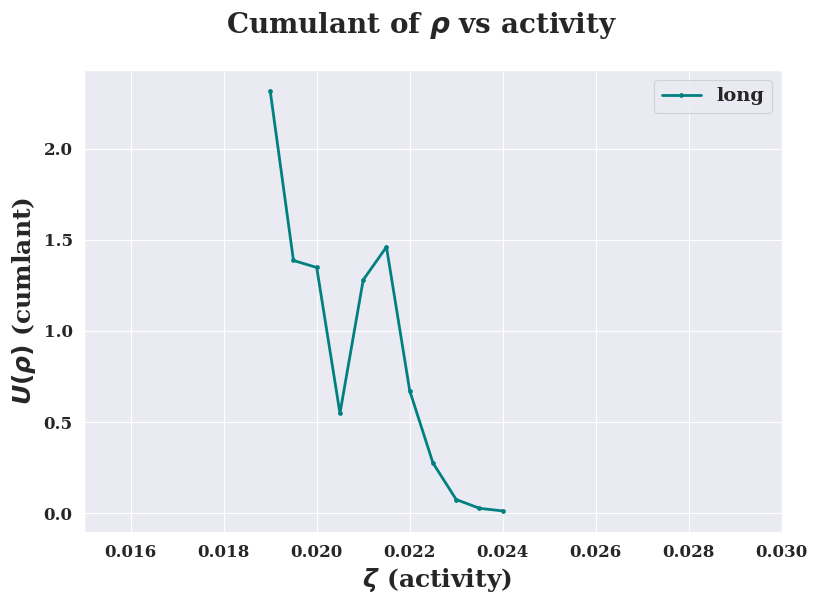

In [18]:
binder_tot_long = 1 - np.nanmean(np.nanmean(defect_arr_long[:,:,:] ** 4, axis = -1), axis = 0) \
  / (3 * np.nanmean(np.nanmean(defect_arr_long[:,:,:] ** 2, axis = -1), axis = 0) ** 2)

# save binder_tot
np.savetxt(os.path.join(save_path, 'binder_tot_long.txt'), binder_tot_long)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(act_list_long, 2/3 - binder_tot_long, '.-', label='long')



ax.set_xlim(0.015, 0.03)
ax.set_xlabel(r' $\zeta$ (activity)')
ax.set_ylabel(r'$U(\rho)$ (cumlant)')
ax.legend(loc='upper right', ncol=2, fontsize = 14)
fig.suptitle(rf'Cumulant of $\rho$ vs activity', fontsize=20)

plt.show()

In [5]:
defect_arr_av_long = np.nanmean(defect_arr_long, axis = 2)
defect_arr_std_long = np.nanstd(defect_arr_long, axis = 2)

min_window_idx=0
first_frame_list = np.array(conv_list)
Nframes_non_nan_counts = Nframes - np.array(first_frame_list)
min_act_idx = 0

In [1]:
ncols = 4
nrows = int(np.ceil(Nactivity_long / ncols))
nrows = 5
fig, ax = plt.subplots(nrows = nrows, ncols = 4, figsize=(28, 13))
ax = ax.flatten()
for i, act in enumerate(act_list_long):
    act_idx = act_list_long.index(act)
    ax[i].errorbar(np.arange(Nframes_long), defect_arr_av_long[:, act_idx], defect_arr_std_long[:, act_idx], label='activity = {}'.format(act), fmt='.', \
                   capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='black')
    
    # plot vertical lines to indicate the start of the averaging
    ax[i].axvline(x=conv_dict[act], color='black', linestyle='--', alpha=0.5)
    ax[i].set_ylim(np.nanmin(defect_arr_av_long[:, act_idx])/2, np.nanmax(defect_arr_av_long[:, act_idx]) + 2  * np.nanmax(defect_arr_std_long[:, act_idx]))

    if i < 3:
        ax[i].text(0.05, 0.9, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')
    else:
        ax[i].text(0.4, 0.1, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='bottom')

fig.suptitle('Defect density for different activities')
fig.supxlabel('Frame')
fig.supylabel('Defect density')

#ax[-1].axis('off')
#ax[-2].axis('off')


plt.tight_layout()
plt.show()

NameError: name 'np' is not defined

In [33]:
def est_stationarity(time_series, interval_len, Njump, Nconverged, max_sigma_dist = 2):
 
    # Estimate the stationarity of a time series by calculating the mean and standard deviation
    # of the time series in intervals of length interval_len. If the mean of a block is sufficiently
    # close to the mean of the entire time series, then the block is considered stationary.

    Nframes = len(time_series)
    Nblocks = int(Nframes / interval_len)
    converged_mean = np.mean(time_series[Nconverged:])
    global_std = np.std(time_series[Nconverged:], ddof = 1)

    it = 0
    while it * Njump < Nframes - interval_len:
        mean_block = np.mean(time_series[it * Njump: it * Njump + interval_len])
        dist_from_mean = np.abs(mean_block - converged_mean) / global_std

        if np.abs(mean_block - converged_mean) > max_sigma_dist * global_std:
            it += 1
        else:
            return it * Njump, True
    return it * Njump, False


In [62]:

exp_conv_list_long = np.ones((Nexp_long, Nactivity_long)).astype(float)


conv_act0021 = np.array([7])
conv_act00215 = np.array([5,6,7])
conv_act0022 = np.array([0,2,5,8])
conv_act00225 = np.array([0,1, 2, 3])
conv_act0023 = np.array([3,4])
conv_act00235 = np.array([0,2,4,6,7,8,9])


In [56]:
del input

In [ ]:
act_idx = 8
ncols = 4
nrows =8


for act_idx in np.arange(Nactivity_long):
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(24, 13))
    ax = ax.flatten()
    mini, maxi = np.nanmin(defect_arr_long[:, act_idx, :]), np.nanmax(defect_arr_long[:, act_idx, : ])
    for i in np.arange(Nexp_long):
        ax[i].plot(np.arange(Nframes_long), defect_arr_long[:, act_idx, i], '.', label='exp = {}'.format(i), alpha = 0.5)
        
        # plot vertical lines to indicate the start of the averaging
        x_conv, converged = est_stationarity(defect_arr_long[:, act_idx, i], 50, 15, 250, 1)
        ax[i].axvline(x=x_conv, color='black', linestyle='--', alpha=0.5)
        ax[i].set_ylim(0.7 * mini, 1.3 * maxi)

    #   print(i, converged)

        ax[i].text(0.05, 0.9, 'Exp = {}'.format(i), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')


    fig.suptitle('Defect count for activity = {}'.format(act_list_long[act_idx]))
    fig.supxlabel('Frame')
    fig.supylabel('Defect count')

    #ax[-1].axis('off')
    #ax[-2].axis('off')
    

    plt.tight_layout()
    plt.show()

    conv = input(f'Enter exp Numbers not converged in format x1,x2,x3,... for  act {act_list_long[act_idx]}')
    if len(conv) > 0:
        conv = np.array(conv.split(',')).astype(int)
        exp_conv_list_long[conv, act_idx] = 0



In [14]:

exp_conv_list = np.ones((Nexp, Nactivity)).astype(float)
exp_conv_list[:, 6:12] = np.nan

conv_act0021 = np.array([7])
conv_act00215 = np.array([5,6,7])
conv_act0022 = np.array([0,2,5,8])
conv_act00225 = np.array([0,1, 2, 3])
conv_act0023 = np.array([3,4])
conv_act00235 = np.array([0,2,4,6,7,8,9])

exp_conv_list[conv_act0021, 6] = 1
exp_conv_list[conv_act00215, 7] = 1
exp_conv_list[conv_act0022, 8] = 1
exp_conv_list[conv_act00225, 9] = 1
exp_conv_list[conv_act0023, 10] = 1
exp_conv_list[conv_act00235, 11] = 1

In [15]:
# load arrays
normalize = True
save = True
act_to_remove = [0.30]

idx_exp_to_keep_list = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
idx_act_to_keep_list = np.where(~np.isin(act_list, act_to_remove))[0]
conv_list = np.delete(conv_list, np.where(np.isin(act_list, act_to_remove))[0])
                 
conv_dict = dict(zip(act_list, conv_list))
act_list = list(np.delete(act_list, np.where(np.isin(act_list, act_to_remove))[0]))
Nactivity = len(act_list)
Nexp = len(idx_exp_to_keep_list)

window_sizes = np.loadtxt(os.path.join(path0, 'window_sizes.txt'))

defect_arr = np.load(os.path.join(save_path, 'defect_arr.npy'))[:, :, idx_exp_to_keep_list][:, idx_act_to_keep_list, :] / LX ** 2
defect_arr_conv = defect_arr * exp_conv_list.T[np.newaxis, :Nactivity, :]

av_defects = np.zeros((Nactivity, 2)) 
defect_arr_av = np.mean(defect_arr, axis=2)
defect_arr_std = np.std(defect_arr, axis=2)

av_defects_conv = np.zeros((Nactivity, 2))
defect_arr_av_conv = np.nanmean(defect_arr_conv, axis=2)
defect_arr_std_conv = np.nanstd(defect_arr_conv, axis=2)

for i, act in enumerate(act_list):
    av_defects[i, 0] = np.mean(defect_arr_av[conv_dict[act]:, i])
    av_defects[i, 1] = np.mean(defect_arr_std[conv_dict[act]:, i]) / np.sqrt(Nframes - conv_dict[act])
    av_defects_conv[i, 0] = np.mean(defect_arr_av_conv[conv_dict[act]:, i])
    av_defects_conv[i, 1] = np.mean(defect_arr_std_conv[conv_dict[act]:, i]) 
av_defects_conv[:, 1] = av_defects_conv[:, 1] / np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity]

av_counts = np.load(os.path.join(save_path, 'av_counts.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
av_counts = av_counts * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]
av_counts_av = np.nanmean(av_counts, axis=3)
av_counts_std = np.nanstd(av_counts, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

var_counts = np.load(os.path.join(save_path, 'var_counts.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
var_counts = var_counts * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]
var_counts_av = np.nanmean(var_counts, axis=3)
var_counts_std = np.nanstd(var_counts, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

dens_fluc = np.load(os.path.join(save_path, 'dens_fluc.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
dens_fluc = dens_fluc * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]
dens_fluc_av = np.nanmean(dens_fluc, axis=3)
dens_fluc_std = np.nanstd(dens_fluc, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

if normalize:
    dens_fluc = dens_fluc / defect_arr[:, None, :, :] ** 2
    dens_fluc_av = np.nanmean(dens_fluc, axis=3)
    dens_fluc_std = np.nanstd(dens_fluc, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

if save:
    np.save(os.path.join(save_path, 'av_defects.npy'), av_defects)
    np.save(os.path.join(save_path, 'av_defects_conv.npy'), av_defects_conv)
    np.savetxt(os.path.join(save_path, 'act_list.txt'), act_list)
    np.save(os.path.join(save_path, 'av_counts_av.npy'), av_counts_av)
    np.save(os.path.join(save_path, 'av_counts_std.npy'), av_counts_std)
    np.save(os.path.join(save_path, 'var_counts_av.npy'), var_counts_av)
    np.save(os.path.join(save_path, 'var_counts_std.npy'), var_counts_std)
    np.save(os.path.join(save_path, 'dens_fluc_av.npy'), dens_fluc_av)
    np.save(os.path.join(save_path, 'dens_fluc_std.npy'), dens_fluc_std)


C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8648\957629013.py:42: RuntimeWarning: Mean of empty slice
  var_counts_av = np.nanmean(var_counts, axis=3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8648\957629013.py:47: RuntimeWarning: Mean of empty slice
  dens_fluc_av = np.nanmean(dens_fluc, axis=3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_8648\957629013.py:52: RuntimeWarning: Mean of empty slice
  dens_fluc_av = np.nanmean(dens_fluc, axis=3)


In [16]:
min_window_idx=6
first_frame_list = np.array(conv_list)
Nframes_non_nan_counts = Nframes - np.array(first_frame_list)

min_act_idx = 7


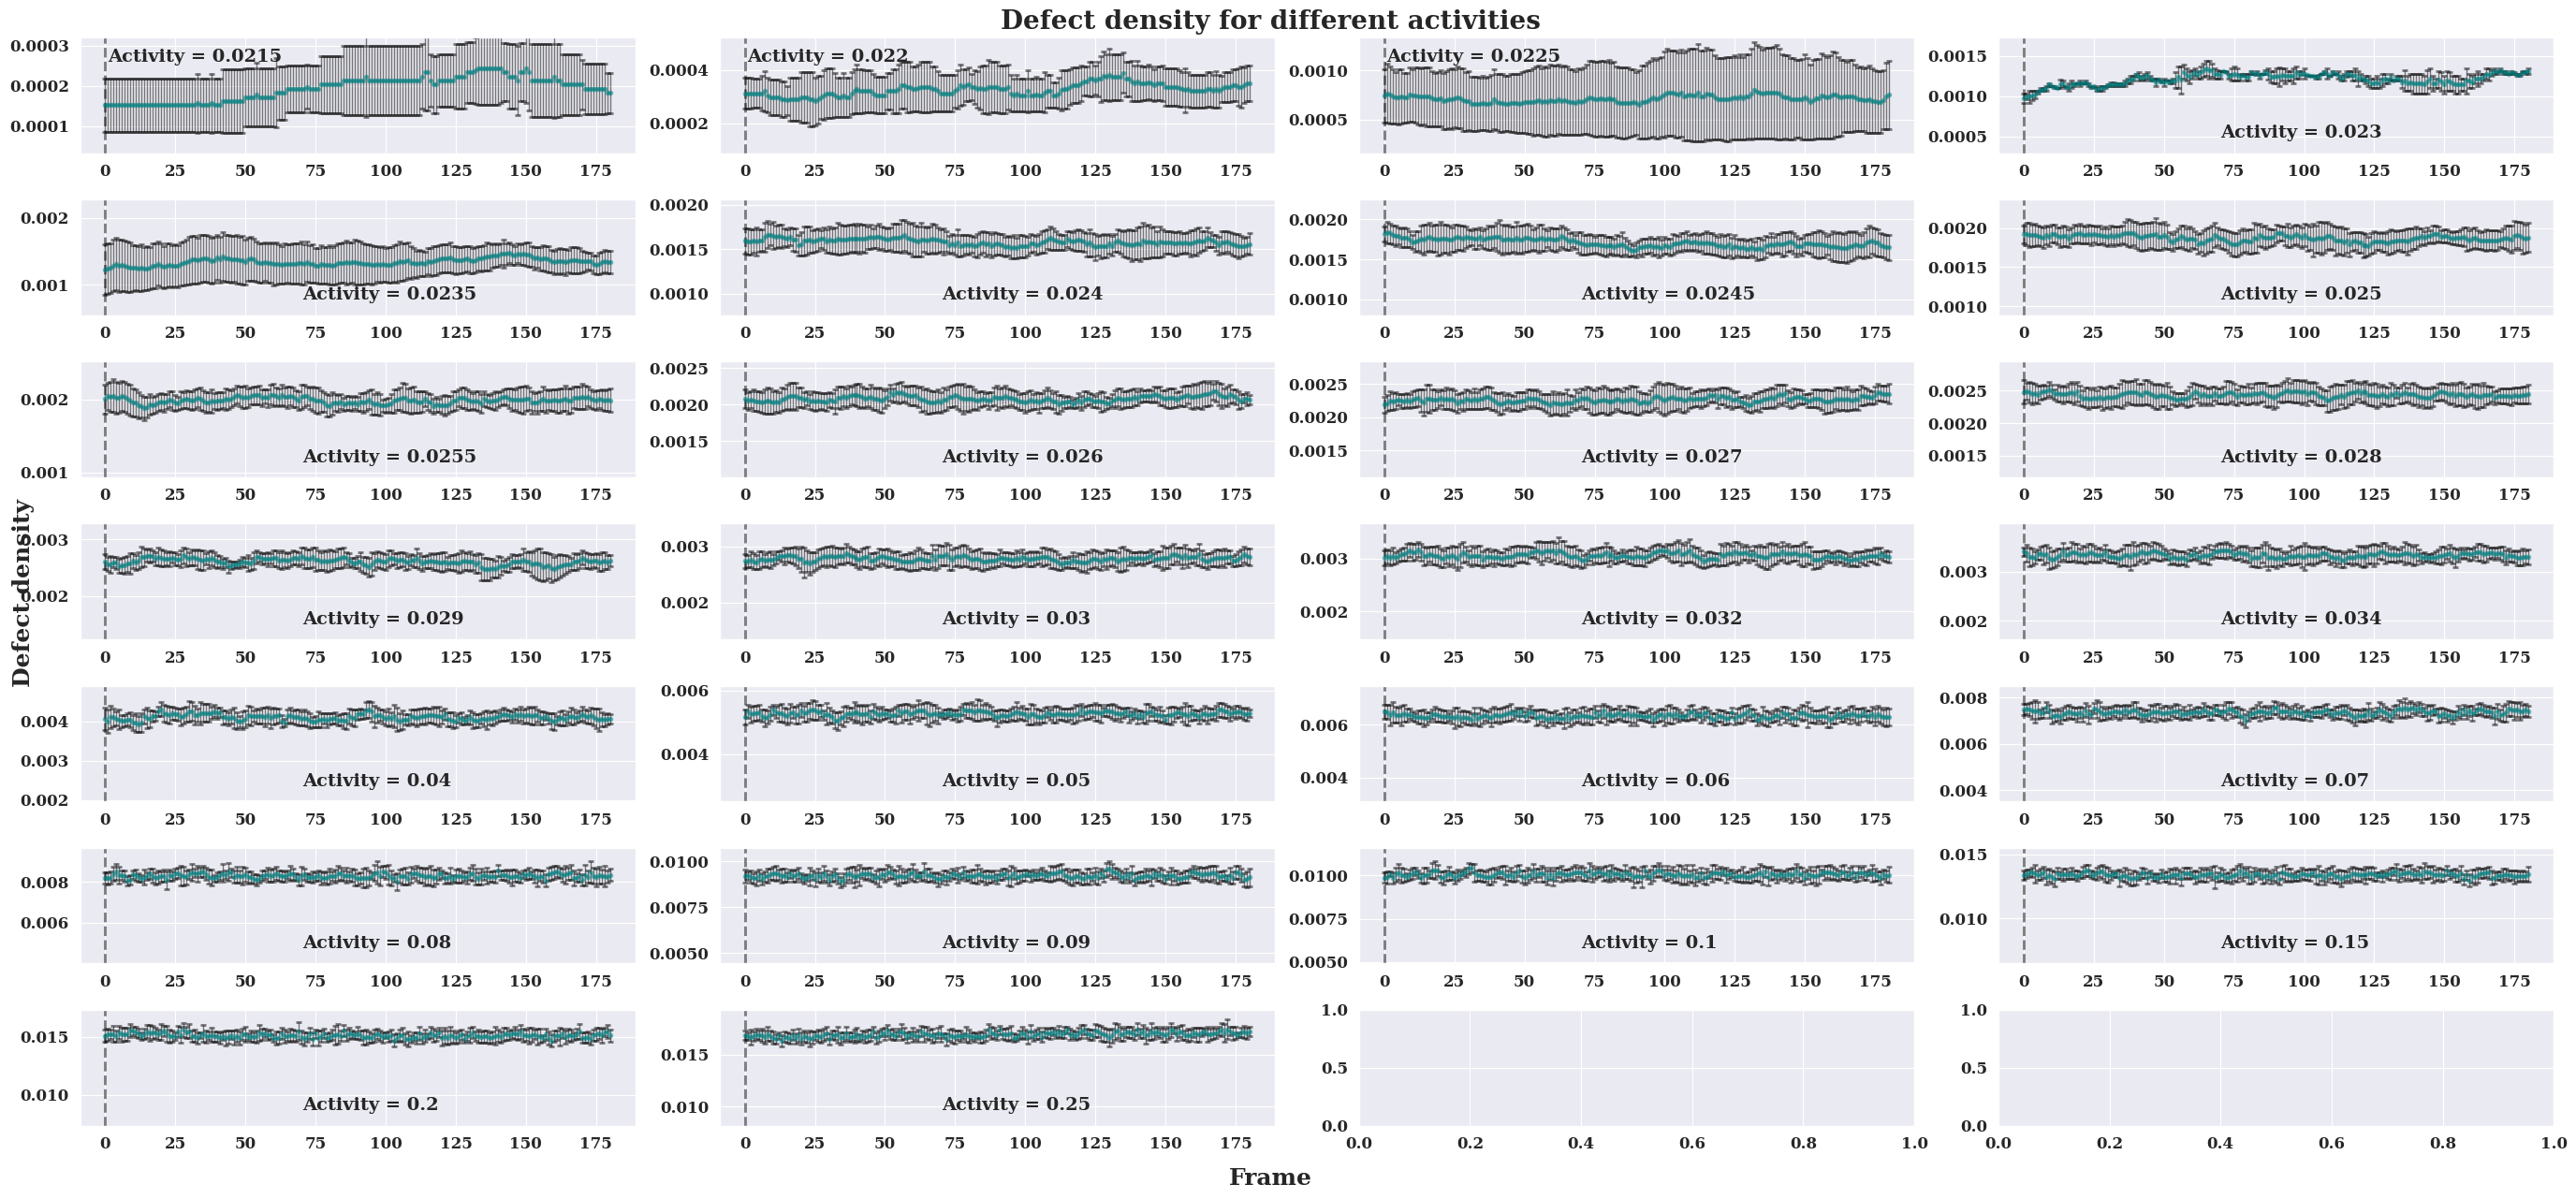

In [160]:
ncols = 4
nrows = int(np.ceil(Nactivity / ncols))
nrows = 7
fig, ax = plt.subplots(nrows = nrows, ncols = 4, figsize=(28, 13))
ax = ax.flatten()
for i, act in enumerate(act_list[min_act_idx:min_act_idx + 26]):
    act_idx = act_list.index(act)
    ax[i].errorbar(np.arange(Nframes), defect_arr_av_conv[:, act_idx], defect_arr_std_conv[:, act_idx], label='activity = {}'.format(act), fmt='.', \
                   capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='black')
    
    # plot vertical lines to indicate the start of the averaging
    ax[i].axvline(x=conv_dict[act], color='black', linestyle='--', alpha=0.5)
    ax[i].set_ylim(np.nanmin(defect_arr_av[:, act_idx])/2, np.nanmax(defect_arr_av[:, act_idx]) + 2  * np.nanmax(defect_arr_std[:, act_idx]))

    if i < 3:
        ax[i].text(0.05, 0.9, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')
    else:
        ax[i].text(0.4, 0.1, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='bottom')

fig.suptitle('Defect density for different activities')
fig.supxlabel('Frame')
fig.supylabel('Defect density')

#ax[-1].axis('off')
#ax[-2].axis('off')


plt.tight_layout()
plt.show()

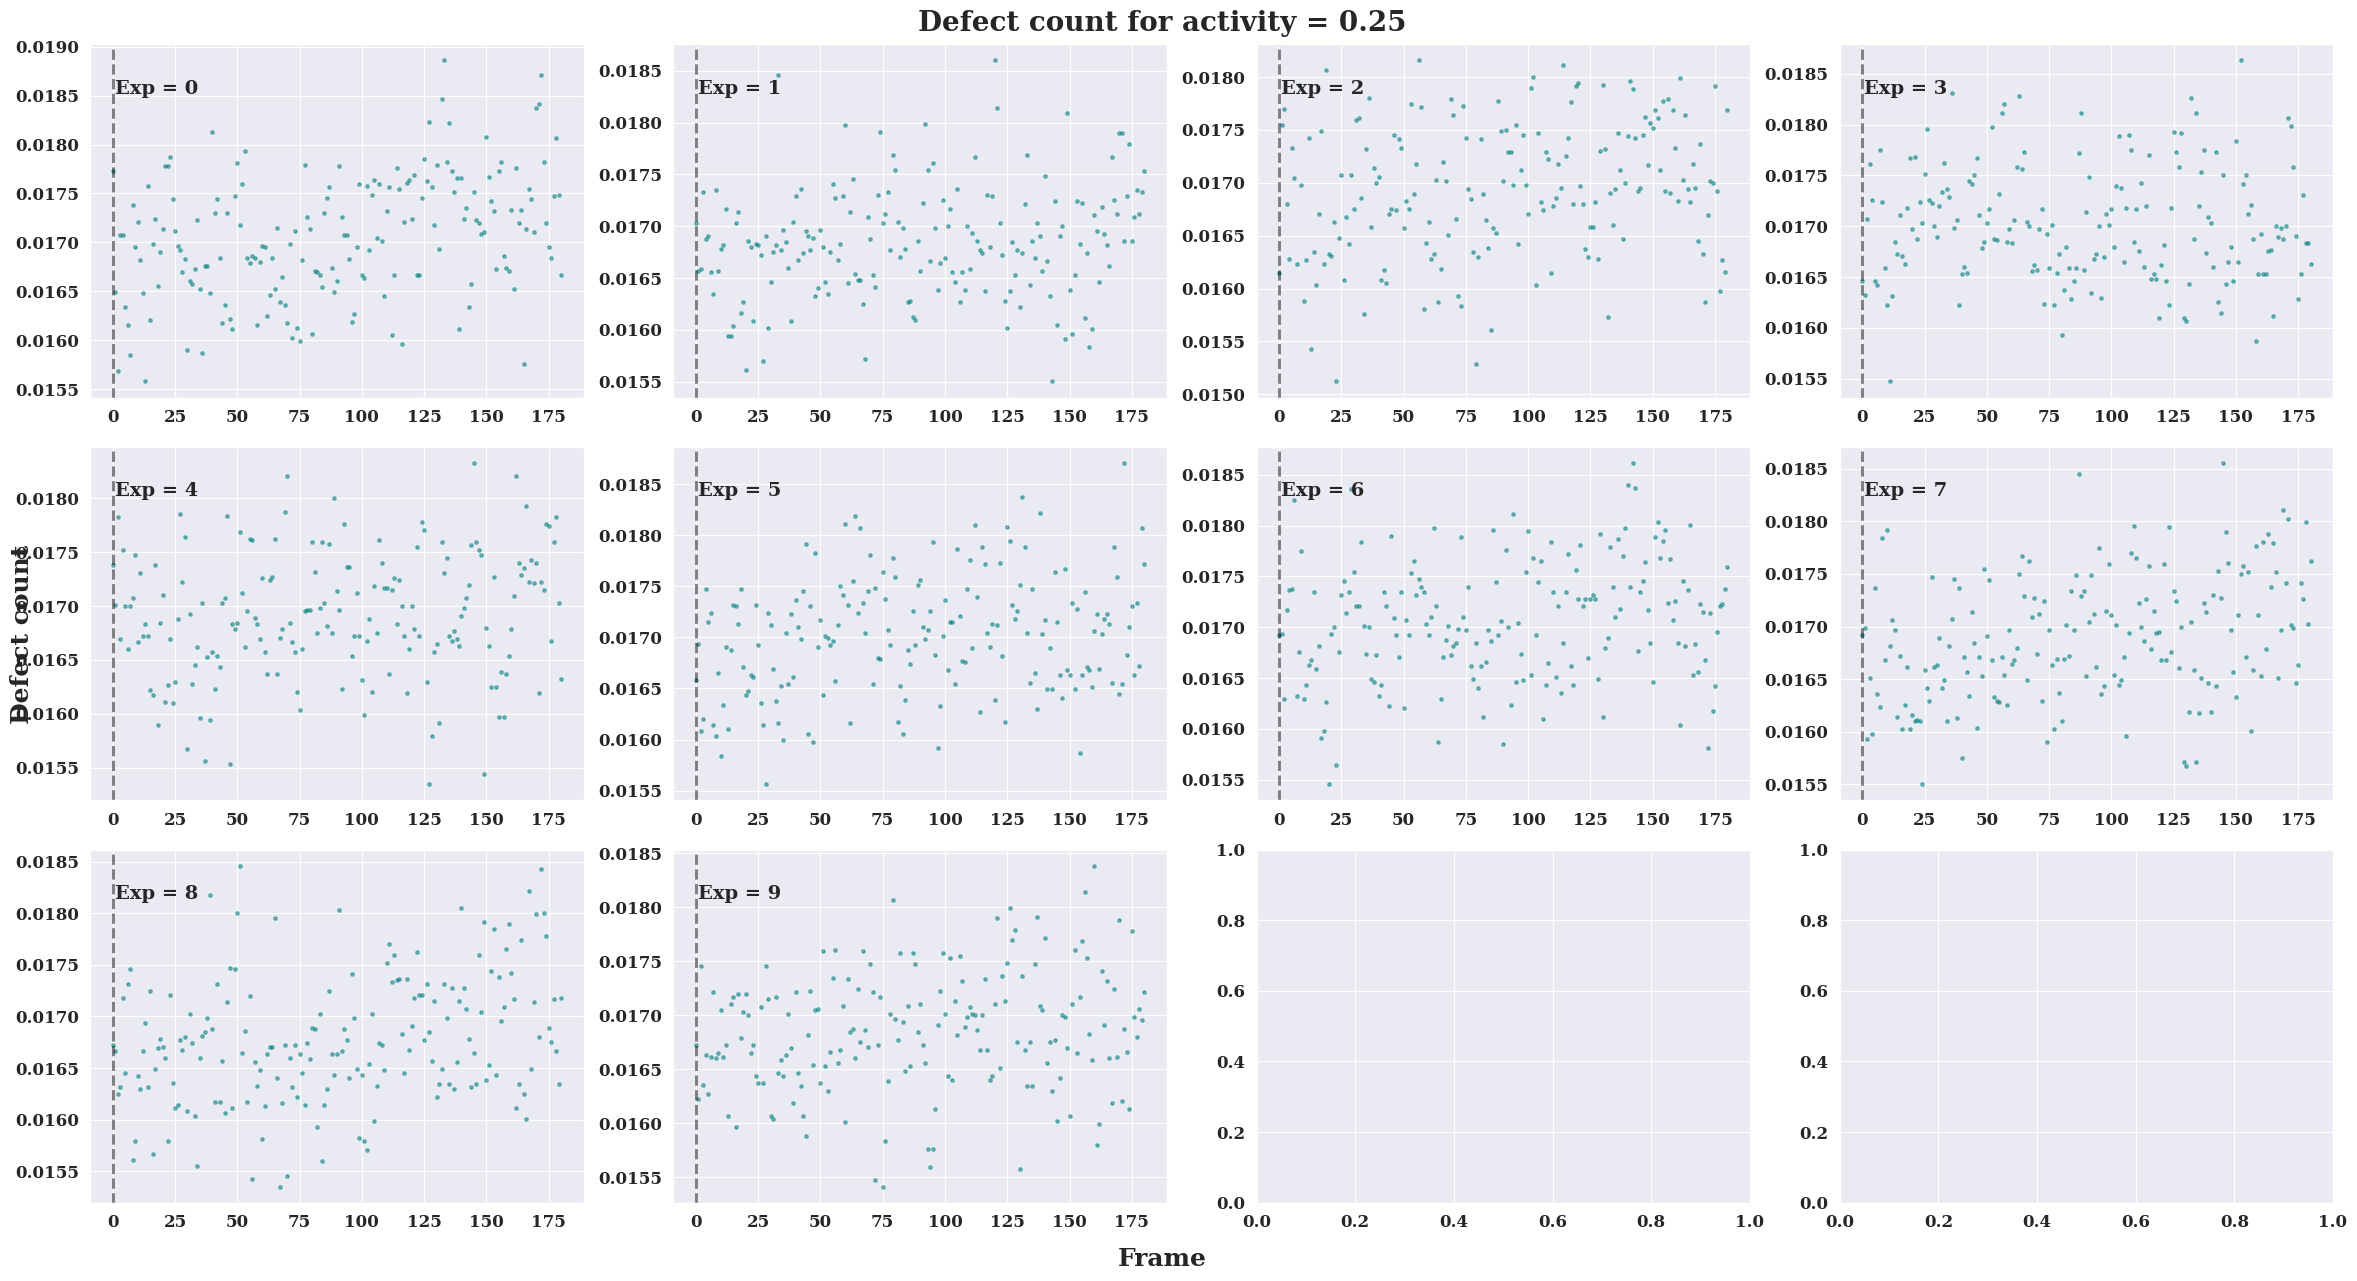

In [236]:
act_idx = -1
ncols = 4
nrows = int(np.ceil(Nactivity / ncols))
nrows = 3
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(24, 13))
ax = ax.flatten()
for i in np.arange(Nexp):
    ax[i].plot(np.arange(Nframes), defect_arr[:, act_idx, i], '.', label='exp = {}'.format(i), alpha = 0.5)
    
    # plot vertical lines to indicate the start of the averaging
    ax[i].axvline(x=conv_dict[act], color='black', linestyle='--', alpha=0.5)
  #  ax[i].set_ylim(np.nanmin(defect_arr_av[:,i])/2, np.nanmax(defect_arr_av[:, i]) + 2  * np.nanmax(defect_arr_std[:, i]))


    ax[i].text(0.05, 0.9, 'Exp = {}'.format(i), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')

fig.suptitle('Defect count for activity = {}'.format(act_list[act_idx]))
fig.supxlabel('Frame')
fig.supylabel('Defect count')

#ax[-1].axis('off')
#ax[-2].axis('off')


plt.tight_layout()
plt.show()

In [17]:
def linear(x, a, b):
    return a * x + b
# Try fitting with other functions
def qudratic(x, a, b, c):
    return a * x**2 + b * x + c
def power(x, a, b, c, d):
    return a * x**d + b * x + c
def log_func(x, a, b, c):
    return a * np.log(x) + b*x + c

In [ ]:
# do a linear fit to the average defect density
param_guess_lin = np.array([70 * 100, 100])
param_guess_quad = np.array([70 * 100, 100, 0])
param_guess_power = np.array([7000, 2, 7100, -29])
param_guess_log = np.array([7000, 300, 30])
fit_func = log_func
fit_string = rf'$y = a x^2 + bx + c$'
fit_string = rf'$y = a \ln x + bx + c $'

param_guess = param_guess_log / LX ** 2
# fit starting with different lower activity values
for i in range(0, len(act_list) - 1):
    lin_fit = do_chi2_fit(fit_func, act_list[i:], av_defects_conv[i:, 0], av_defects_conv[i:, 1], parameter_guesses= param_guess, verbose=False)

    print("Fitting only activities >= {}".format(act_list[i]))
    Ndof, chi2, pval = get_statistics_from_fit(lin_fit, len(act_list[i:]))
    print("Ndof, chi2, pval: ", Ndof, np.round(chi2, 2), np.round(pval, 7))
print("\n\n")

 
lower_act_index = act_list.index(0.0225)

lin_fit = do_chi2_fit(fit_func, act_list[lower_act_index:], av_defects_conv[lower_act_index:, 0], av_defects_conv[lower_act_index:, 1], parameter_guesses= param_guess, verbose=False)
Ndof, chi2, pval = get_statistics_from_fit(lin_fit, len(act_list[lower_act_index:]))


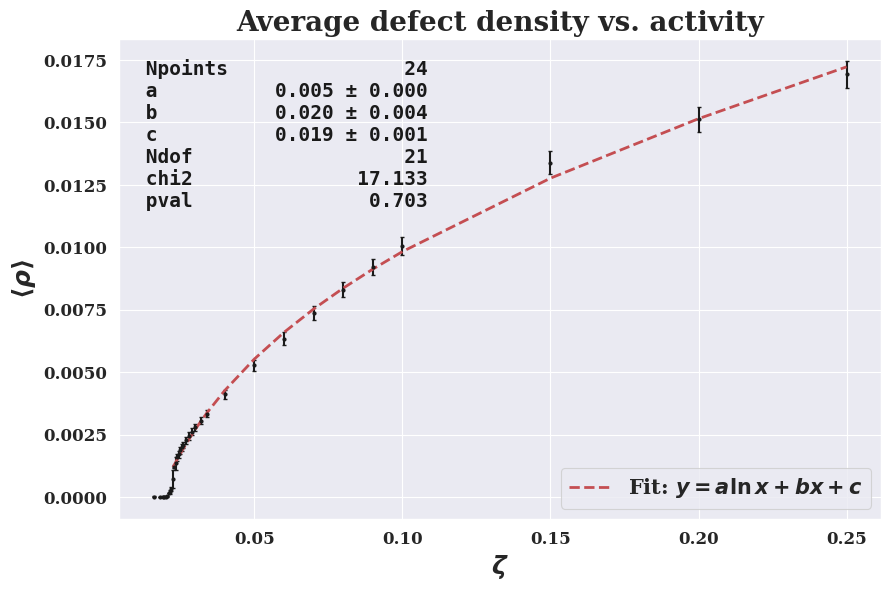

In [190]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(act_list, av_defects_conv[:, 0], yerr = av_defects_conv[:, 1], fmt = 'k.', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4)
ax.set_xlabel(r'$\zeta$')
ax.set_ylabel(r'$\langle \rho \rangle$')
ax.set_title('Average defect density vs. activity')

ax.plot(act_list[lower_act_index:], fit_func(np.array(act_list[lower_act_index:]), *lin_fit.values[:]), 'r--', label=rf'Fit: {fit_string}')

d = {'Fit1: y = a1x + b1': '', 'a1': [lin_fit.values['a'], lin_fit.errors['a']], 'b1': [lin_fit.values['b'],lin_fit.errors['b'] ],\
      'Fit1 Ndof1': Ndof, 'chi2val1': chi2, 'pval1': pval}

d = generate_dictionary(lin_fit, len(act_list[lower_act_index:]), chi2_suffix = None)

#d.update(d_lower)
text = nice_string_output(d, extra_spacing=4, decimals=3)
add_text_to_ax(0.02, 0.96, text, ax, fontsize=14)
ax.legend(loc='lower right')

fig.tight_layout()
plt.show()

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_14196\1281463970.py:1: RuntimeWarning: invalid value encountered in true_divide
  rel_error = var_counts_std[:,min_window_idx:,:] / var_counts_av[:,min_window_idx:,:]
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_14196\1281463970.py:2: RuntimeWarning: Mean of empty slice
  rel_error_av = np.nanmean(rel_error, axis=0)
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


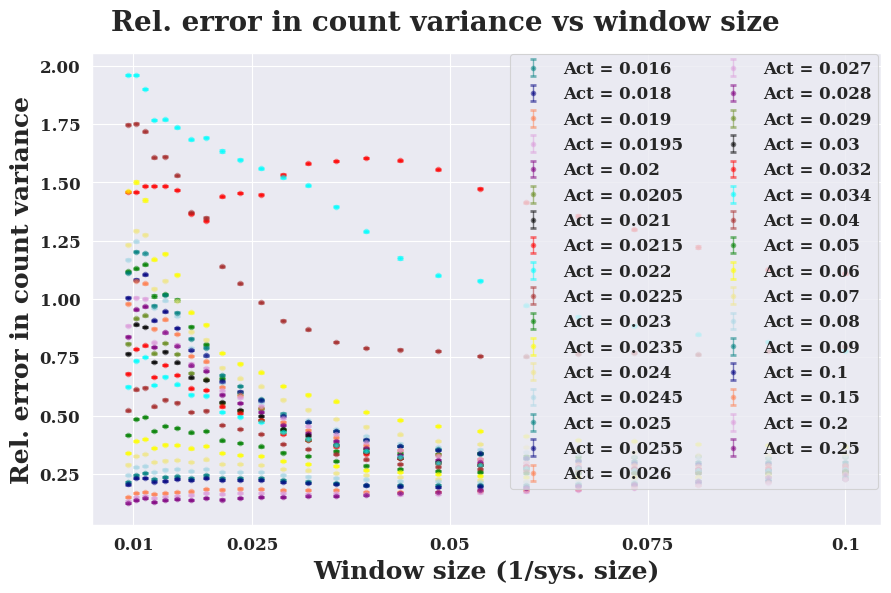

In [191]:

rel_error = var_counts_std[:,min_window_idx:,:] / var_counts_av[:,min_window_idx:,:]
rel_error_av = np.nanmean(rel_error, axis=0)

rel_error_std = np.nanstd(rel_error, axis=0, ddof=1) / Nframes_non_nan_counts[np.newaxis, :]

fig, ax = plt.subplots(figsize=(9,6))
for i, act in enumerate(act_list):
    ax.errorbar(window_sizes[min_window_idx:], rel_error_av[:,i], rel_error_std[:,i], fmt='.', label = f'Act = {act}',\
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
    
ax.set_xlabel('Window size (1/sys. size)')
ax.set_ylabel('Rel. error in count variance')
fig.suptitle('Rel. error in count variance vs window size')
#ax.legend(loc='upper right')

xticks = np.array([1, 2.5, 5, 7.5, 10]) * 2.56
ax.set_xticks(xticks, labels = np.round(xticks / 256,3))
fig.legend(ncol=2, fontsize = 12, bbox_to_anchor=(0.99, 0.92))
fig.tight_layout()

In [222]:
def lin_func(x, alpha, beta):
    return beta * (2 - alpha) + (2 - alpha) * x
def power_func(x, b): #, c, d, e):
    return  b * x ** 2
def power_log_func(x, b): #, c, d, e):
    return  b * x ** 2 * np.log(x)

param_guess_lin = np.array([0.1, 0.3])
param_guess_power = np.array([2400])
param_guess_power_log = np.array([2000])

R = window_sizes[min_window_idx:]

fit_func = lin_func
param_guess = param_guess_lin
log_fit = True
fit_string = rf'$y = \beta(2-\alpha) + (2-\alpha)x$'
save_suffix = 'lin'


# Initial arrays to store the fit parameters and errors for all activities and frames
Nparams = len(param_guess)
fit_params = np.zeros([Nframes, len(act_list), 2 * Nparams]) * np.nan
stat_arr = np.zeros([Nframes, len(act_list), 3]) * np.nan

In [235]:
for i, act in enumerate(act_list):  
    if act < act_list[min_act_idx]:
        continue
    for frame in np.arange(first_frame_list[i], Nframes):
        count_var_av = var_counts_av[frame, min_window_idx:, i]
        count_var_std = var_counts_std[frame, min_window_idx:, i]

        if log_fit:
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=np.runtimewarning)
                    x = np.log(R)
                    y = np.log(count_var_av)
                    yerr = count_var_std / count_var_av
            except:
                continue
        else:
            x = R
            y = count_var_av
            yerr = count_var_std

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
            fit = do_chi2_fit(fit_func, x, y, yerr, param_guess, verbose = False)

        Ndof, chi2, prop = get_statistics_from_fit(fit, len(R), subtract_1dof_for_binning = False)
 
        fit_params[frame, i, :Nparams] = fit.values[:]
        fit_params[frame, i, Nparams:] = fit.errors[:]
        stat_arr[frame, i, :] = Ndof, chi2, prop

print("Non-converged fits: ", np.nansum((stat_arr[:, :, -1] < 0.05)))

# save
np.save(os.path.join(save_path, f'fit_params_{save_suffix}_normalize{normalize}.npy'), fit_params)
np.save(os.path.join(save_path, f'stat_arr_{save_suffix}_normalize{normalize}.npy'), stat_arr)

Non-converged fits:  31


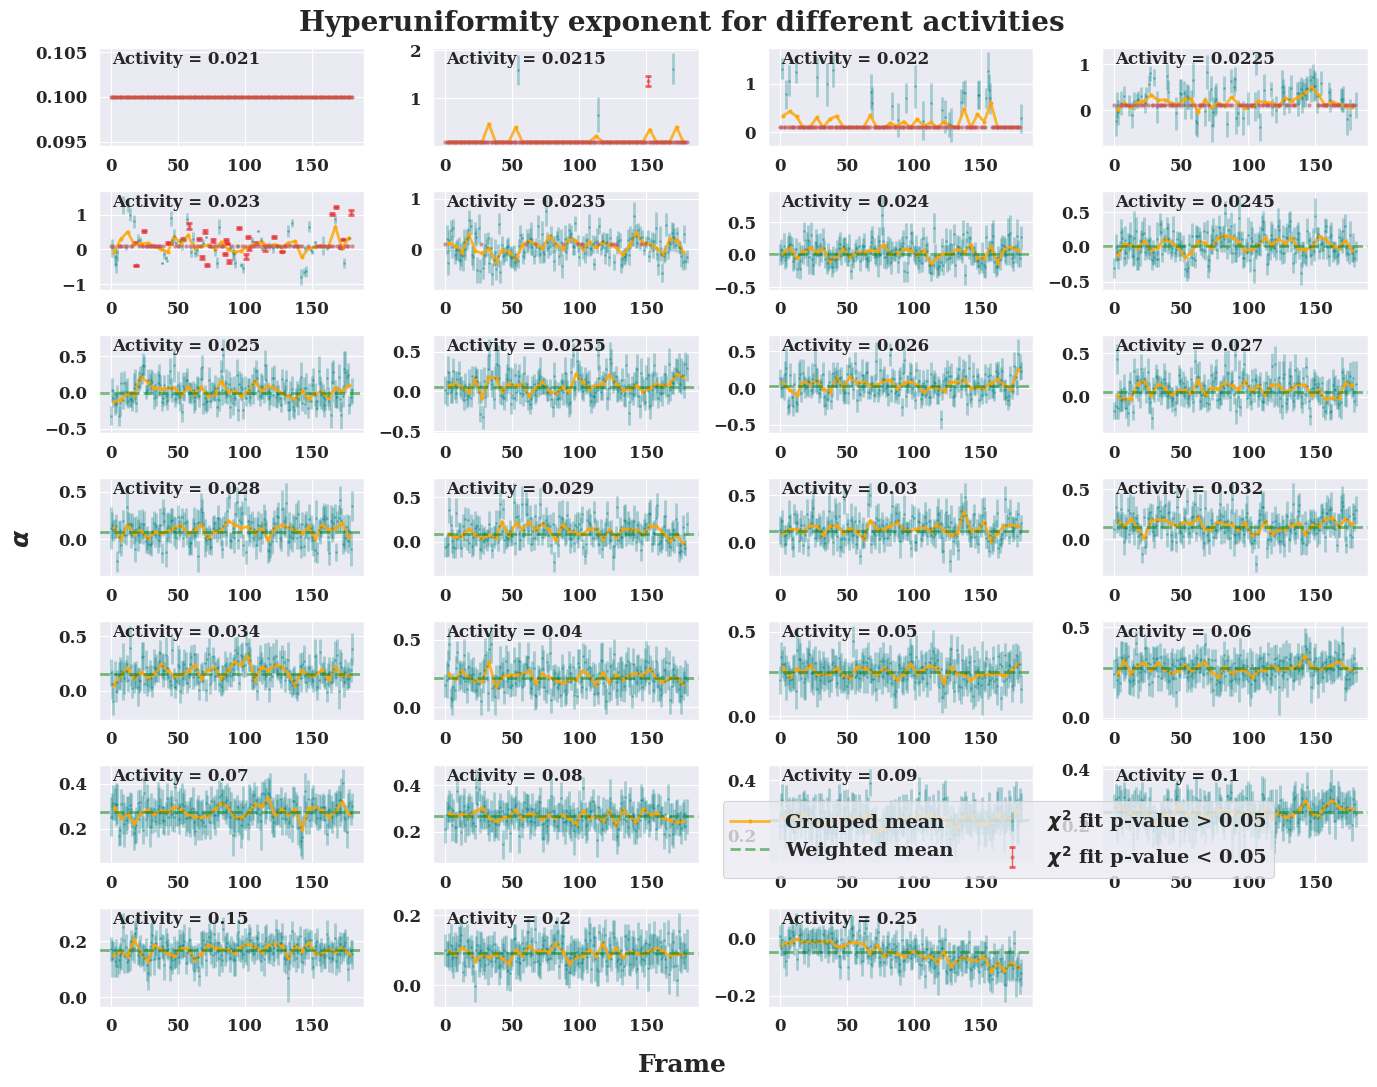

In [234]:
fig, ax = plt.subplots(nrows = 7, ncols = 4, figsize=(14, 11))

ax = ax.flatten()
Ngroup = 5

for i, act in enumerate(act_list[min_act_idx:]):
    act_idx = act_list.index(act)
    
    if i == 0:
        label1 = rf'$\chi^2$ fit p-value > 0.05'
        label2 = rf'$\chi^2$ fit p-value < 0.05'
        label3 = 'Weighted mean'
        label4 = 'Grouped mean'
    else:
        label1 = None
        label2 = None
        label3 = None
        label4 = None

    p_mask = stat_arr[first_frame_list[act_idx]:, act_idx, 2] > 0.05

    ax[i].errorbar(np.arange(first_frame_list[act_idx], Nframes)[p_mask], \
                   fit_params[first_frame_list[act_idx]:,act_idx,0][p_mask], \
                    fit_params[first_frame_list[act_idx]:,act_idx,Nparams][p_mask], \
                       fmt='.', \
                   alpha = 0.3, markersize=2, label = label1)# ecolor='black')capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, 
    
    ax[i].errorbar(np.arange(first_frame_list[act_idx], Nframes)[~p_mask], \
                     fit_params[first_frame_list[act_idx]:,act_idx,0][~p_mask], \
                      fit_params[first_frame_list[act_idx]:,act_idx,Nparams][~p_mask], \
                        fmt='r.', \
                     capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.6, markersize=2, ecolor='red', label = label2)

    x = fit_params[first_frame_list[act_idx]:, act_idx, 0]

    max_idx = len(x) - len(x) % Ngroup 
    # group the data and calculate the weighted mean and error on mean
    x_group = x[:max_idx].reshape(-1, Ngroup).mean(axis=1)
    dx_group = np.std(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)
    x_frames = np.arange(first_frame_list[act_idx], first_frame_list[act_idx] + max_idx, Ngroup) + Ngroup / 2

    # plot x_group and dx_group
    ax[i].plot(x_frames, x_group, '.-', color='orange', alpha=0.8, markersize=4, label = label4)
    if 0:
        ax[i].errorbar(x_frames, \
                    x_group, \
                        dx_group, \
                        fmt='.', \
                    alpha = 0.5, markersize=4, ecolor='orange')


    mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x_group, dx_group)
    #ax[i].axhline(mean, color='orange', linestyle='-', alpha=0.5, lw = 2, label = label3)
    

    # calc and plot weighted mean and error on mean for all frames and activities
    mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x, fit_params[first_frame_list[i]:, act_idx, Nparams])
    ax[i].axhline(mean, color='green', linestyle='--', alpha=0.5, lw = 2, label = label3)
    
    # plot vertical lines to indicate the start of the averaging
  #  ax[i].axhline(0, color='black', linestyle='--', alpha=0.5)
    #ax[i].set_ylim(np.min(defect_arr_av[:,i])/2, np.max(defect_arr_av[:, i]) + 2  * np.max(defect_arr_std[:, i]))
    ax[i].text(0.05, 0.97, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=12, verticalalignment='top')
    if 0:
        if i < 3:
            ax[i].text(0.05, 0.9, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')
        else:
            ax[i].text(0.4, 0.1, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='bottom')

#ax[-2].axis('off')
ax[-1].axis('off')

fig.suptitle('Hyperuniformity exponent for different activities')
fig.supxlabel('Frame')
fig.supylabel(rf'$\alpha$')
fig.legend(ncol=2, fontsize = 14,bbox_to_anchor=(0.93, 0.27))

plt.tight_layout()
plt.show()

In [20]:
def lin_func_dens(x, alpha, beta):
    return beta * (- 2 - alpha) + (- 2 - alpha) * x
def power_func(x, b): #, c, d, e):
    return  b * x ** 2
def power_log_func(x, b): #, c, d, e):
    return  b * x ** 2 * np.log(x)

param_guess_lin_dens = np.array([0.1, 0.1])
param_guess_power = np.array([2400])
param_guess_power_log = np.array([2000])

R = window_sizes[min_window_idx:]

fit_func = lin_func_dens
param_guess = param_guess_lin_dens
log_fit = True
fit_string = rf'$y = -\beta(2+\alpha) - (2+\alpha)x$'
save_suffix = 'lin'


# Initial arrays to store the fit parameters and errors for all activities and frames
Nparams = len(param_guess)
fit_params_time_av = np.zeros([len(act_list), 2 * Nparams]) * np.nan
stat_arr_time_av = np.zeros([len(act_list), 3]) * np.nan




In [22]:
Nframes_non_nan_counts

array([181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181,
       181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181,
       181, 181, 181, 181, 181, 181, 181])

[     nan      nan      nan      nan      nan      nan      nan      nan
      nan  0.21503  0.11947  0.08676  0.05112  0.05017  0.03705  0.096
  0.06479  0.10211  0.11393  0.12149  0.16297  0.15612  0.18276  0.23024
  0.26343  0.27424  0.2765   0.2648   0.25921  0.24622  0.16694  0.09096
 -0.05243]
[    nan     nan     nan     nan     nan     nan     nan     nan     nan
 0.99982 0.00186 0.61291 0.96844 0.7544  0.80992 0.92497 0.39499 0.65913
 0.75797 0.41938 0.85048 0.69619 0.63571 0.2179  0.11748 0.17309 0.02087
 0.00215 0.00044 0.00005 0.      0.      0.     ]


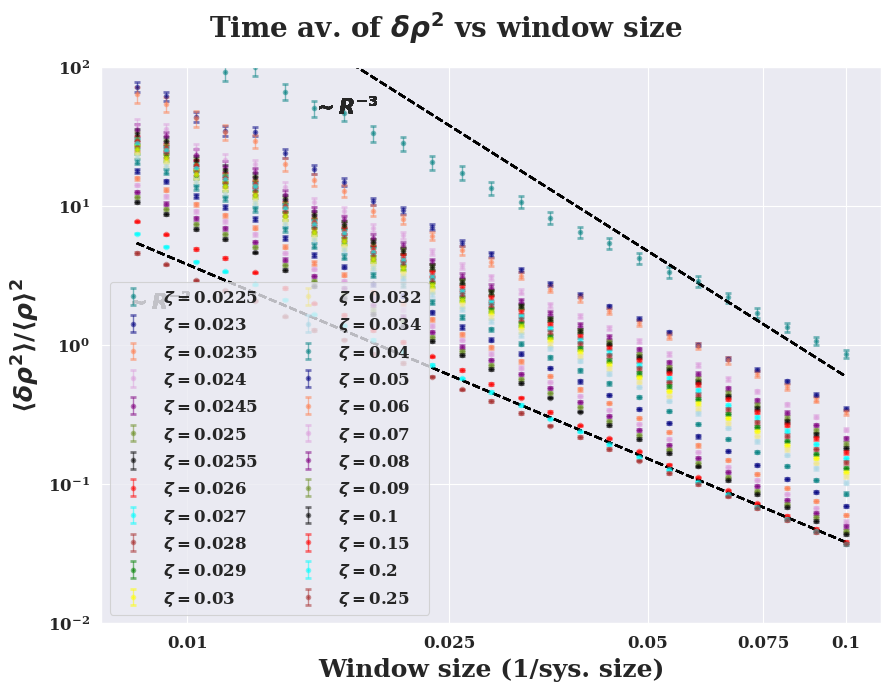

In [21]:
frame = 30
min_window_idx = 5

fig, ax = plt.subplots(figsize=(9,7))
for i, act in enumerate(act_list):
    if act < 0.0225:
        continue

    frames_av_dens = np.mean(dens_fluc_av[first_frame_list[i]:, min_window_idx:,i], axis = 0)
    frames_av_dens_std = np.mean(dens_fluc_std[first_frame_list[i]:, min_window_idx:,i], axis = 0) \
                      / np.sqrt(Nframes_non_nan_counts[i])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
        fit = do_chi2_fit(fit_func, np.log(R), np.log(frames_av_dens), frames_av_dens_std / frames_av_dens, param_guess, verbose = False)

    Ndof, chi2, prop = get_statistics_from_fit(fit, len(R), subtract_1dof_for_binning = False)

    fit_params_time_av[i, :Nparams] = fit.values[:]
    fit_params_time_av[i, Nparams:] = fit.errors[:]
    stat_arr_time_av[i, :] = Ndof, chi2, prop


    ax.errorbar(window_sizes[min_window_idx:], frames_av_dens, \
                frames_av_dens_std, fmt='.', label = fr'$\zeta = ${act}',\
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)

    ax.plot(window_sizes[min_window_idx:], 25 / window_sizes[min_window_idx:] ** (2), '--', color='black', alpha=0.5, lw = 1.5)
    ax.text(0.03, 0.6, r'$\sim R^{-2}$', fontsize=15, transform=ax.transAxes, verticalalignment='top', fontweight='normal')

    ax.plot(window_sizes[min_window_idx:], 10000/ window_sizes[min_window_idx:] ** (3), '--', color='black', alpha=0.5, lw = 1.5)
    ax.text(0.27, 0.95, r'$\sim R^{-3}$', transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight='normal')

ax.set_xlabel('Window size (1/sys. size)')
ax.set_ylabel(rf'$\langle \delta \rho ^2 \rangle /  \langle \rho \rangle ^2$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(bottom=0.01, top = 100)
xticks = np.array([1, 2.5, 5, 7.5, 10]) * 2.56
ax.set_xticks(xticks, labels = np.round(xticks / 256,3))
ax.legend(ncol=2, fontsize = 12, loc = 'lower left') 

fig.suptitle(rf'Time av. of $ \delta \rho^2$ vs window size')
fig.tight_layout()

print(fit_params_time_av[:,0])
print(stat_arr_time_av[:,-1])

np.save(os.path.join(save_path, f'fit_params_{save_suffix}_normalize{normalize}_time_av.npy'), fit_params_time_av)
np.save(os.path.join(save_path, f'stat_arr_{save_suffix}_normalize{normalize}_time_av.npy'), stat_arr_time_av)


c:\Users\Simon Andersen\Projects\Projects\Thesis\HyperUniformity\utils.py:226: RuntimeWarning: divide by zero encountered in true_divide
  var = 1 / np.sum(1 / dx ** 2)
c:\Users\Simon Andersen\Projects\Projects\Thesis\HyperUniformity\utils.py:227: RuntimeWarning: divide by zero encountered in true_divide
  mean = np.sum(x / dx ** 2) * var
c:\Users\Simon Andersen\Projects\Projects\Thesis\HyperUniformity\utils.py:227: RuntimeWarning: invalid value encountered in double_scalars
  mean = np.sum(x / dx ** 2) * var


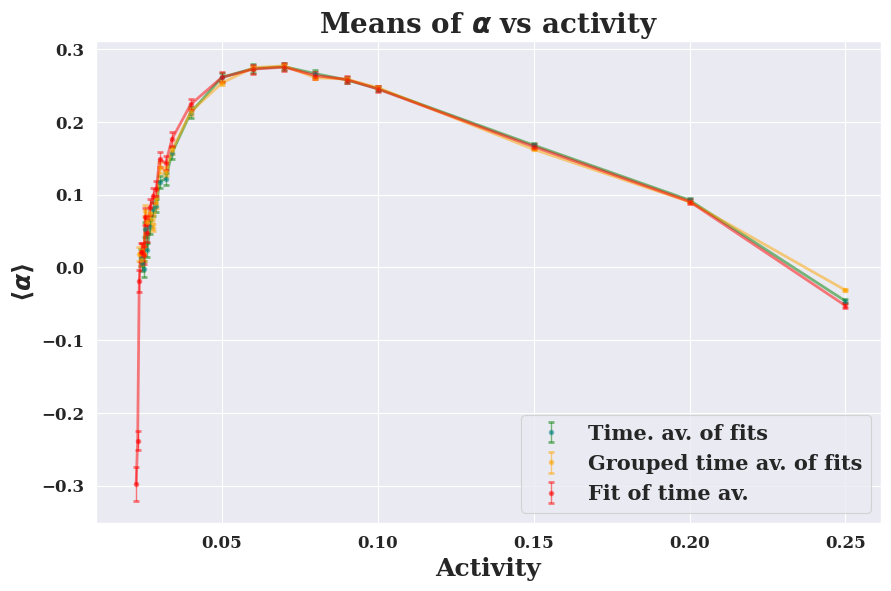

In [232]:
# calc weighted mean and error on mean for all frames and activities

Ngroup = 5
group = True
weighted_means_list = []
weighted_errs_list = []
weighted_means_group_list = []
weighted_errs_group_list = []

for i, act in enumerate(act_list):
        if act < act_list[min_act_idx]:
               continue
        
        if group:
                x = fit_params[first_frame_list[i]:, i, 0]

                max_idx = len(x) - len(x) % Ngroup
                # group the data and calculate the weighted mean and error on mean
                x_group = x[:max_idx].reshape(-1, Ngroup).mean(axis=1)
                dx_group = np.std(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)

                mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x_group, dx_group)
                weighted_means_group_list.append(mean)
                weighted_errs_group_list.append(err)
      
        if 1:
             #   p_mask = (0.05 < stat_arr[first_frame_list[i]:, i, 2])  
                x = fit_params[first_frame_list[i]:, i, 0][p_mask]
                dx = fit_params[first_frame_list[i]:, i, Nparams][p_mask]

        try:
                mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x, dx)
                weighted_means_list.append(mean)
                weighted_errs_list.append(err)
        except:
                print("No fits for activity = {}".format(act))
                weighted_means_list.append(np.nan)
                weighted_errs_list.append(np.nan)


fig2, ax2 = plt.subplots(figsize=(9,6))
ax2.errorbar(act_list[min_act_idx:], weighted_means_list, weighted_errs_list, fmt='.', label = 'Time. av. of fits', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='green')
ax2.plot(act_list[min_act_idx:], weighted_means_list, '-', color='green', alpha=0.5, )
ax2.errorbar(act_list[min_act_idx:], weighted_means_group_list, weighted_errs_group_list, fmt='.', label = 'Grouped time av. of fits', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='orange', color = 'orange')
ax2.plot(act_list[min_act_idx:],weighted_means_group_list,  '-',color='orange', alpha=0.5)
ax2.errorbar(act_list[min_act_idx:], fit_params_time_av[min_act_idx:,0], fit_params_time_av[min_act_idx:,Nparams], fmt='.', label = 'Fit of time av.', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='red', color = 'red'
             )
ax2.plot(act_list[min_act_idx:], fit_params_time_av[min_act_idx:,0], '-', color='red', alpha=0.5)

ax2.set_xlabel('Activity')
ax2.set_ylabel(rf'$\langle\alpha \rangle$')
ax2.set_title(rf'Means of $\alpha $ vs activity')
ax2.legend()
fig2.tight_layout()

In [239]:
min_window_idx

5

In [240]:
act_list

[0.016,
 0.018,
 0.019,
 0.0195,
 0.02,
 0.0205,
 0.021,
 0.0215,
 0.022,
 0.0225,
 0.023,
 0.0235,
 0.024,
 0.0245,
 0.025,
 0.0255,
 0.026,
 0.027,
 0.028,
 0.029,
 0.03,
 0.032,
 0.034,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.15,
 0.2,
 0.25]

In [259]:
xi_av[:,6]

array([  0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
         0.     ,   0.     ,   0.     ,   0.9895 ,   0.65458,   0.43302,
         0.28646,   4.42209,   9.52506,   8.4509 ,   8.99944,   7.6235 ,
        13.54005,  22.39139,  21.15529,  23.6402 ,  23.04063,  20.75977,
        31.29647,  31.85621,  36.40463,  33.11315,  68.55439, 314.01872])

In [283]:
np.argmax(xi_av[min_window_idx:, min_act_idx:], axis = 1)

array([5, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       2, 0, 0], dtype=int64)

In [289]:
xi_av[:,4]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_14196\815049692.py:3: RuntimeWarning: Mean of empty slice
  xi_av =  np.nanmean(dens_fluc_av, axis = 0) #* window_sizes[:, None]**2  #** 2
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


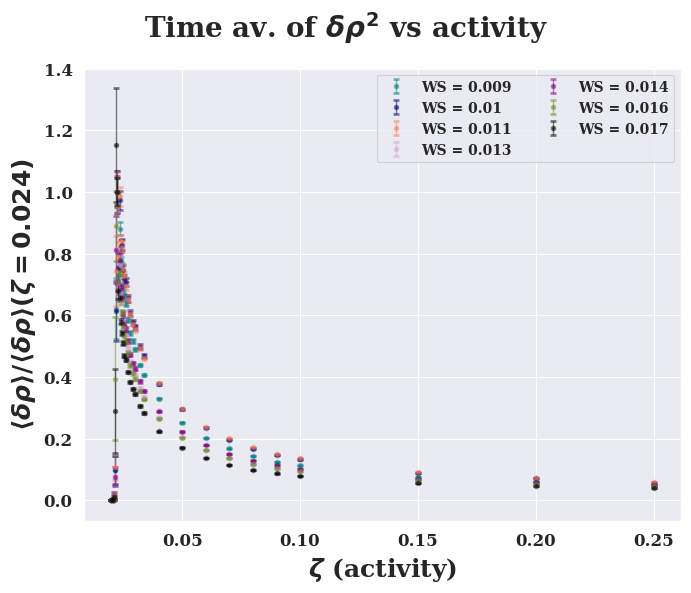

In [297]:
logplot = False

xi_av =  np.nanmean(dens_fluc_av, axis = 0) #* window_sizes[:, None]**2  #** 2
xi_std = np.nanstd(dens_fluc_av, axis = 0, ddof=1) / np.sqrt(Nframes_non_nan_counts[np.newaxis, :]) #* window_sizes[:, None]**2 #** 2

fig, ax = plt.subplots(figsize=(7,6))

for j, window in enumerate(window_sizes[min_window_idx:]):
        norm =  xi_av[j + min_window_idx, min_act_idx + 3]
        if j in [1,2,3,4,5,6,7]:
            ax.errorbar(act_list[min_act_idx-2:], xi_av[j + min_window_idx, min_act_idx-2:] / norm,\
                            xi_std[j + min_window_idx, min_act_idx-2:] / norm, label=f'WS = {np.round(window / 256,3)}', fmt='.', \
                   capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)

ax.set_xlabel(rf'$\zeta$ (activity)')
ax.set_ylabel(r'$\langle \delta \rho \rangle / \langle \delta \rho \rangle (\zeta = 0.024) $')

if logplot:
  #  ax.set_yscale('log')
    ax.set_xscale('log')

#add legend above the plot in 3 rows
ax.legend(loc='upper right', ncol=2, fontsize = 10,)
fig.suptitle(rf'Time av. of $\delta \rho ^2$ vs activity', fontsize=20)
fig.tight_layout()
plt.show()

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_14196\3163861671.py:5: RuntimeWarning: invalid value encountered in true_divide
  binder_cumulants = 1 - np.nanmean(np.nanmean((av_counts/(np.pi * window_sizes[None,:,None,None]**2)) ** 4, axis = -1), axis = 0) \


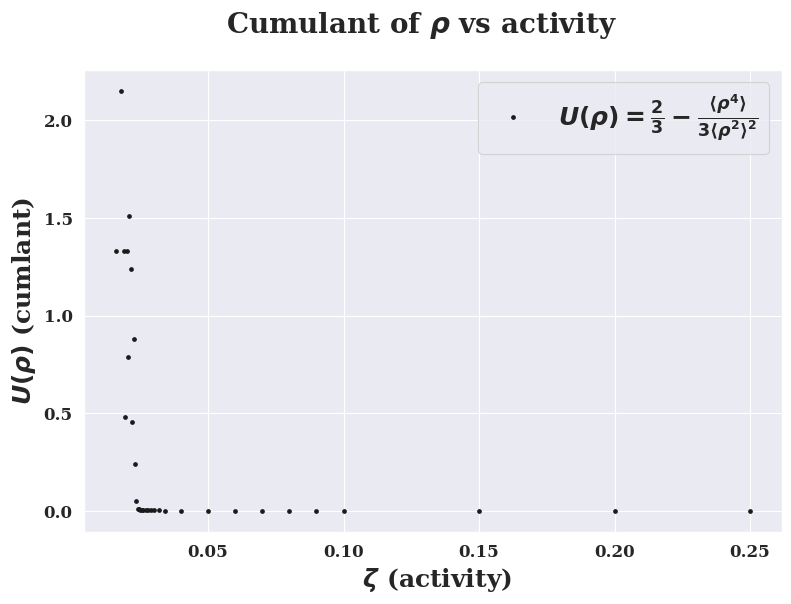

In [296]:
binder_tot = 1 - np.nanmean(np.nanmean(defect_arr[:,:,:] ** 4, axis = -1), axis = 0) \
  / (3 * np.nanmean(np.nanmean(defect_arr[:,:,:] ** 2, axis = -1), axis = 0) ** 2)


binder_cumulants = 1 - np.nanmean(np.nanmean((av_counts/(np.pi * window_sizes[None,:,None,None]**2)) ** 4, axis = -1), axis = 0) \
  / (3 * np.nanmean(np.nanmean((av_counts/(np.pi * window_sizes[None,:,None,None]**2)) ** 2, axis = -1), axis = 0) ** 2)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(act_list, 2/3 - binder_tot, 'k.', label=r'$U(\rho) = \frac{2}{3} - \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2}$')

ax.set_xlabel(r' $\zeta$ (activity)')
ax.set_ylabel(r'$U(\rho)$ (cumlant)')
ax.legend(loc='upper right', ncol=2, fontsize = 18)
fig.suptitle(rf'Cumulant of $\rho$ vs activity', fontsize=20)

plt.show()